<a href="https://colab.research.google.com/github/mertege/FMCW-Data-Classification-/blob/Range-Doppler-Spectrogram-LSTM/RD_SP_LSTM_denseunit128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Normalization, Input, Conv2D, MaxPooling2D, Concatenate, GRU, LSTM, GRU, TimeDistributed, Bidirectional
import tensorflow as tf
import scipy.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from numpy.random import seed
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import EarlyStopping
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras import backend as K 
import gc
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Get Range-Doppler data from
range_doppler_fast_resized = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_fast_resized.mat')
range_doppler_fast_resized = range_doppler_fast_resized['range_doppler_fast_resized']
range_doppler_fast_resized = np.transpose(range_doppler_fast_resized, (2, 0, 1))
# range_doppler_fast_resized = np.delete(range_doppler_fast_resized,(49), axis=0) # 50th row is deleted since there is no 50th row in spectrogram fast data.
range_doppler_fast_label = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_fast_label.mat')
range_doppler_fast_label = range_doppler_fast_label['range_doppler_fast_label']  

range_doppler_slow_resized = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_slow_resized.mat')
range_doppler_slow_resized = range_doppler_slow_resized['range_doppler_slow_resized']
range_doppler_slow_resized = np.transpose(range_doppler_slow_resized, (2, 0, 1))
range_doppler_slow_label = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_slow_label.mat')
range_doppler_slow_label = range_doppler_slow_label['range_doppler_slow_label']  

range_doppler_slow_pocket_resized = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_slow_pocket_resized.mat')
range_doppler_slow_pocket_resized = range_doppler_slow_pocket_resized['range_doppler_slow_pocket_resized']
range_doppler_slow_pocket_resized = np.transpose(range_doppler_slow_pocket_resized, (2, 0, 1))
range_doppler_pocket_label = scipy.io.loadmat('/content/drive/MyDrive/data/range_doppler_pocket_label.mat')
range_doppler_pocket_label = range_doppler_pocket_label['range_doppler_pocket_label']  
# Get Range-Doppler data from
spectrogram_fast_resized = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_fast_resized.mat')
spectrogram_fast_resized = spectrogram_fast_resized['spectrogram_fast_resized']
spectrogram_fast_resized = np.transpose(spectrogram_fast_resized, (2, 0, 1))
spectrogram_fast_label = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_fast_label.mat')
spectrogram_fast_label = spectrogram_fast_label['spectrogram_fast_label']  

spectrogram_slow_resized = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_resized.mat')
spectrogram_slow_resized = spectrogram_slow_resized['spectrogram_slow_resized']
spectrogram_slow_resized = np.transpose(spectrogram_slow_resized, (2, 0, 1))
spectrogram_slow_label = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_label.mat')
spectrogram_slow_label = spectrogram_slow_label['spectrogram_slow_label']  

spectrogram_slow_pocket_resized = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_pocket_resized.mat')
spectrogram_slow_pocket_resized = spectrogram_slow_pocket_resized['spectrogram_slow_pocket_resized']
spectrogram_slow_pocket_resized = np.transpose(spectrogram_slow_pocket_resized, (2, 0, 1))
spectrogram_slow_pocket_label = scipy.io.loadmat('/content/drive/MyDrive/data/spectrogram_slow_pocket_label.mat')
spectrogram_slow_pocket_label = spectrogram_slow_pocket_label['spectrogram_slow_pocket_label']  

In [4]:
# Concat range-doppler data
range_doppler_concat = np.concatenate((range_doppler_fast_resized,range_doppler_slow_resized),axis=0)
range_doppler_concat = np.concatenate((range_doppler_concat,range_doppler_slow_pocket_resized),axis=0)
range_doppler_concat = range_doppler_concat[:,:,:,np.newaxis] 
range_doppler_concat_label = np.zeros((range_doppler_concat.shape[0],1))
range_doppler_concat_label[:range_doppler_fast_resized.shape[0],:] = 1
# Shuffle concat range doppler
shuffle_indx = random.sample(range(0, range_doppler_concat.shape[0]), range_doppler_concat.shape[0]) # split validation data
range_doppler_concat_shuffle = range_doppler_concat[shuffle_indx,:,:,:]
range_doppler_concat_label_shuffle = range_doppler_concat_label[shuffle_indx,:]
# Concat range-doppler data
spectrogram_concat = np.concatenate((spectrogram_fast_resized,spectrogram_slow_resized),axis=0)
spectrogram_concat = np.concatenate((spectrogram_concat,spectrogram_slow_pocket_resized),axis=0)
spectrogram_concat = spectrogram_concat[:,:,:,np.newaxis] 
spectrogram_concat_label = np.zeros((spectrogram_concat.shape[0],1))
spectrogram_concat_label[:spectrogram_fast_resized.shape[0],:] = 1
# Shuffle concat range doppler
# shuffle_indx = random.sample(range(0, spectrogram_concat.shape[0]), spectrogram_concat.shape[0]) # split validation data
spectrogram_concat_shuffle = spectrogram_concat[shuffle_indx,:,:,:]
spectrogram_concat_label_shuffle = spectrogram_concat_label[shuffle_indx,:]

In [5]:
# ---------------- Augmente and shuffle (train and test) data data ----------------
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
])


def mixup_augmentation(images,range_doppler_training_data, labels, repeat_of_mixup, alpha=0.2):
    batch_size = images.shape[0]
    concat_images = np.zeros((batch_size*(repeat_of_mixup+1),images.shape[1],images.shape[2],images.shape[3]))
    concat_images_range_doppler = np.zeros((batch_size*(repeat_of_mixup+1),range_doppler_training_data.shape[1],\
                                            range_doppler_training_data.shape[2],range_doppler_training_data.shape[3]))
    concat_label = np.zeros((batch_size*(repeat_of_mixup+1),labels.shape[1]))
    for ii in range(repeat_of_mixup):
      # shuffle train dataset
      shuffle_indx_1 = random.sample(range(0, images.shape[0]), images.shape[0]) # split validation data
      images_shuffled_1 = images[shuffle_indx_1,:,:,:]
      range_doppler_training_data_shuffled_1 = range_doppler_training_data[shuffle_indx_1,:,:,:]
      labels_shuffled_1 = labels[shuffle_indx_1,:]

      shuffle_indx_2 = random.sample(range(0, images.shape[0]), images.shape[0]) # split validation data
      images_shuffled_2 = images[shuffle_indx_2,:,:,:]
      range_doppler_training_data_shuffled_2 = range_doppler_training_data[shuffle_indx_2,:,:,:]
      labels_shuffled_2 = labels[shuffle_indx_2,:]

      # Sample lambda and reshape it to do the mixup
      gaussian_mean = 0.2
      gaussian_std = 0.02
      ll = np.random.normal(gaussian_mean, gaussian_std, (batch_size,1,1,1))
      x_l = np.reshape(ll, (batch_size,1,1,1))
      y_l = np.reshape(ll, (batch_size,1))
      
      # Perform mixup on both images and labels by combining a pair of images/labels
      images_mixup = images_shuffled_1 * x_l + images_shuffled_2 * (1 - x_l)
      images_mixup_range_doppler = range_doppler_training_data_shuffled_1 * x_l + range_doppler_training_data_shuffled_2 * (1 - x_l)
      labels_mixup = labels_shuffled_1 * y_l + labels_shuffled_2 * (1 - y_l)
      concat_images[ii*batch_size:(ii+1)*batch_size,:,:,:] = images_mixup
      concat_images_range_doppler[ii*batch_size:(ii+1)*batch_size,:,:,:] = images_mixup_range_doppler
      concat_label[ii*batch_size:(ii+1)*batch_size,:] = labels_mixup

    concat_images[repeat_of_mixup*batch_size:,:,:,:] = images
    concat_images_range_doppler[repeat_of_mixup*batch_size:,:,:,:] = range_doppler_training_data
    concat_label[repeat_of_mixup*batch_size:,:] = labels
    return (concat_images,concat_images_range_doppler, concat_label)
def split_and_augmentation_of_training(spectrogram_concat_shuffle_train,range_doppler_concat_shuffle_train,range_doppler_concat_label_shuffle_train,\
                                       repeat_of_mixup, augmentation_enable):
  # ---------------- Parameters ----------------
  repeat_of_augmentation_for_fast = 1
  repeat_of_augmentation_for_slow = np.floor(repeat_of_augmentation_for_fast/2)
  repeat_of_augmentation_for_slow = int(repeat_of_augmentation_for_slow)
  # size_of_validation = 30
  alpha = 0.2
  dummy_label = np.zeros((spectrogram_concat_shuffle_train.shape[0],1))
  for randomlist_for_train_indx, randomlist_for_validation_indx in kfold.split(spectrogram_concat_shuffle_train,dummy_label):   
    randomlist_for_validation_indx
  # Split validation
  # randomlist_for_validation_indx = random.sample(range(0, range_doppler_concat_shuffle_train.shape[0]), size_of_validation) # split validation data
  # randomlist_for_train_indx = np.delete(range(0, range_doppler_concat_shuffle_train.shape[0]), randomlist_for_validation_indx) # split training data
  # get validation data
  spectrogram_validation_data = spectrogram_concat_shuffle_train[randomlist_for_validation_indx,:,:,:]
  spectrogram_validation_labels = range_doppler_concat_label_shuffle_train[randomlist_for_validation_indx,:]
  range_doppler_validation_data = range_doppler_concat_shuffle_train[randomlist_for_validation_indx,:,:,:]
  # get training data
  spectrogram_training_data = spectrogram_concat_shuffle_train[randomlist_for_train_indx,:,:,:]
  spectrogram_training_labels = spectrogram_concat_label_shuffle_train[randomlist_for_train_indx,:]
  range_doppler_training_data = range_doppler_concat_shuffle_train[randomlist_for_train_indx,:,:,:]

  # Rotate Augmentation
  # get slow and fast indexes of training data
  slow_indexes = np.where(spectrogram_training_labels == 0)[0]
  fast_indexes = np.delete(range(0, spectrogram_training_labels.shape[0]), slow_indexes)  

  slow_spectrograms_train = spectrogram_training_data[slow_indexes,:,:,:]
  size_of_samples_slow = slow_spectrograms_train.shape[0]

  fast_spectrograms_train = spectrogram_training_data[fast_indexes,:,:,:]  
  size_of_samples_fast = fast_spectrograms_train.shape[0]

  slow_range_train = range_doppler_training_data[slow_indexes,:,:,:]
  fast_range_train = range_doppler_training_data[fast_indexes,:,:,:]  

  if augmentation_enable == True: 
    # ---------------- Augmente Train Data for Fast ----------------
    augmented_image_fast = np.zeros((size_of_samples_fast*repeat_of_augmentation_for_fast,fast_spectrograms_train.shape[1],fast_spectrograms_train.shape[2],1))
    spectrograms_fast_label = np.ones((size_of_samples_fast*(repeat_of_augmentation_for_fast+1),1))
    # augmented_image_fast = np.flip(fast_spectrograms_train,axis=2)
    for jj in range(repeat_of_augmentation_for_fast):
      for ii in range(size_of_samples_fast):
        augmented_image_fast[size_of_samples_fast*jj+ii,:,:,:] = data_augmentation(fast_spectrograms_train[ii,:,:,:])
    augmented_image_fast = np.concatenate((augmented_image_fast,fast_spectrograms_train),axis=0)   

    augmented_image_fast_range = np.zeros((size_of_samples_fast*repeat_of_augmentation_for_fast,fast_range_train.shape[1],fast_range_train.shape[2],1))
    # augmented_image_fast_range  = np.flip(fast_range_train,axis=2)
    for jj in range(repeat_of_augmentation_for_fast):
      for ii in range(size_of_samples_fast):
        augmented_image_fast_range[size_of_samples_fast*jj+ii,:,:,:]  =data_augmentation(fast_range_train[ii,:,:,:])
    augmented_image_fast_range = np.concatenate((augmented_image_fast_range,fast_range_train),axis=0)   

    # ---------------- Augmente Train Data for Slow ----------------
    augmented_image_slow = slow_spectrograms_train
    augmented_image_slow_range = slow_range_train

  else:
    augmented_image_fast = fast_spectrograms_train
    augmented_image_slow = slow_spectrograms_train
    augmented_image_fast_range = fast_range_train
    augmented_image_slow_range = slow_range_train
    spectrograms_fast_label = np.ones((size_of_samples_fast,1))
    
  spectrograms_slow_label = np.zeros((size_of_samples_slow,1))

  spectrogram_training_data = np.concatenate((augmented_image_fast,augmented_image_slow),axis=0)
  range_doppler_training_data = np.concatenate((augmented_image_fast_range,augmented_image_slow_range),axis=0)
  spectrogram_training_labels = np.concatenate((spectrograms_fast_label,spectrograms_slow_label),axis=0)

  (spectrogram_augmented_image,range_doppler_augmented_image,spectrograms_label)=\
   mixup_augmentation(spectrogram_training_data,range_doppler_training_data, spectrogram_training_labels, repeat_of_mixup, alpha=0.2)

  return (spectrogram_augmented_image,range_doppler_augmented_image,spectrograms_label,\
     spectrogram_validation_data,range_doppler_validation_data, spectrogram_validation_labels)
def normalize_inputs(range_doppler_concat_shuffle, normalize_inputs_enable):
  # ---------------- Normalize Inputs ----------------
  if normalize_inputs_enable == True:
    layer = Normalization(axis=None)
    layer.adapt(range_doppler_concat_shuffle)
    range_doppler_concat_shuffle = layer(range_doppler_concat_shuffle)
  else:
    range_doppler_concat_shuffle = range_doppler_concat_shuffle
  return(range_doppler_concat_shuffle)

In [6]:
normalize_inputs_enable = 1
range_doppler_concat_shuffle = normalize_inputs(range_doppler_concat_shuffle, normalize_inputs_enable)
spectrogram_concat_shuffle = normalize_inputs(spectrogram_concat_shuffle, normalize_inputs_enable)
range_doppler_concat_shuffle = np.float32(range_doppler_concat_shuffle)
spectrogram_concat_shuffle = np.float32(spectrogram_concat_shuffle)


In [7]:
n_features = range_doppler_concat_shuffle.shape[1]
n_steps = range_doppler_concat_shuffle.shape[2]
range_doppler_concat_shuffle = np.transpose(range_doppler_concat_shuffle, axes = (0,2,1,3)) 
spectrogram_concat_shuffle = np.transpose(spectrogram_concat_shuffle, axes = (0,2,1,3)) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 batch_normalization (BatchN  (None, 163840)           655360    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 163840)            0         
                                                                 
 dense (Dense)               (None, 128)               209716

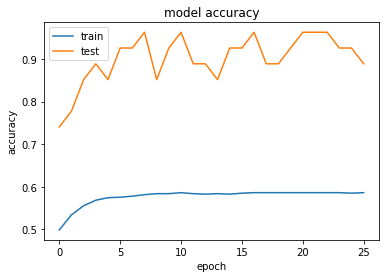

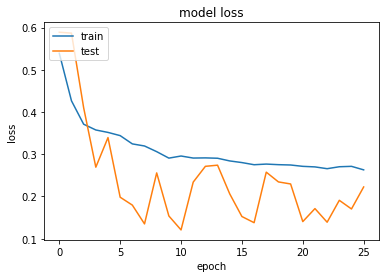

2/2 [==============================] - 2s 126ms/step - loss: 0.1381 - accuracy: 0.9412
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 batch_normalization (BatchN  (None, 163840)           655360    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 163840)            0         
                                        

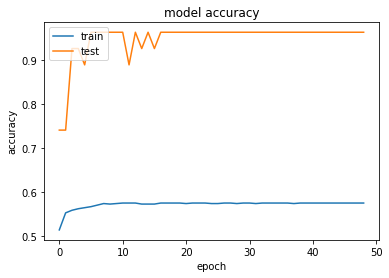

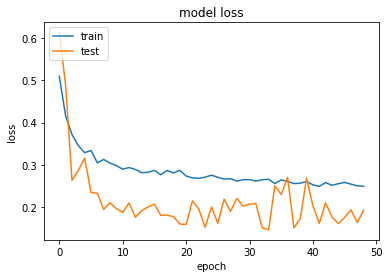

2/2 [==============================] - 1s 121ms/step - loss: 0.1852 - accuracy: 0.9412
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 batch_normalization (BatchN  (None, 163840)           655360    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 163840)            0         
                                        

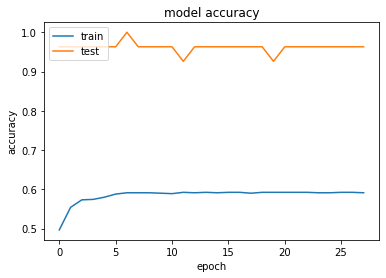

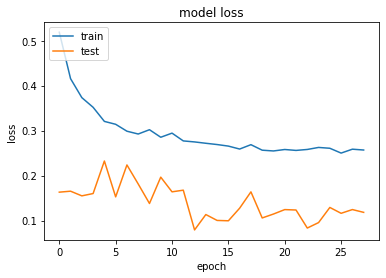

2/2 [==============================] - 2s 124ms/step - loss: 0.0783 - accuracy: 0.9706
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 batch_normalization (BatchN  (None, 163840)           655360    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 163840)            0         
                                        

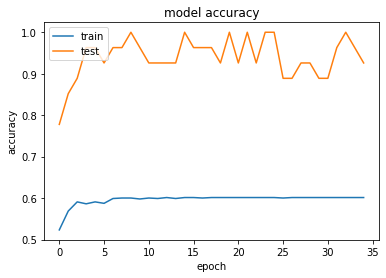

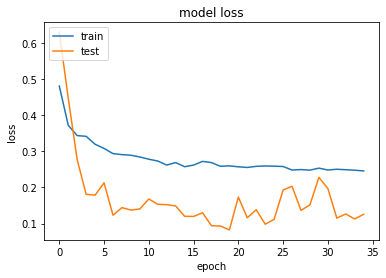

2/2 [==============================] - 2s 124ms/step - loss: 0.2483 - accuracy: 0.8824
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5120, 52)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 5120, 32)         8832      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 163840)            0         
                                                                 
 batch_normalization (BatchN  (None, 163840)           655360    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 163840)            0         
                                        

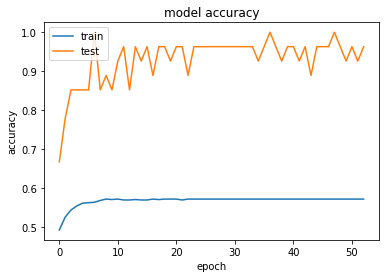

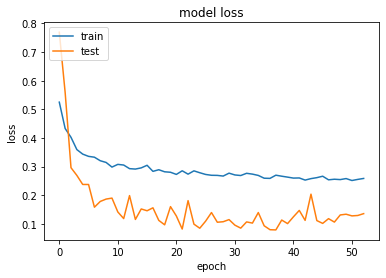

2/2 [==============================] - 1s 120ms/step - loss: 0.1141 - accuracy: 0.9412
[0.9352941155433655]
[0.9263087228836536]
Epoch 1/100
27/27 [==============================] - 16s 382ms/step - loss: 0.5159 - accuracy: 0.5128 - val_loss: 0.2600 - val_accuracy: 0.8148
Epoch 2/100
27/27 [==============================] - 9s 329ms/step - loss: 0.3914 - accuracy: 0.5653 - val_loss: 0.4136 - val_accuracy: 0.7407
Epoch 3/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3646 - accuracy: 0.5711 - val_loss: 0.1717 - val_accuracy: 1.0000
Epoch 4/100
27/27 [==============================] - 9s 332ms/step - loss: 0.3337 - accuracy: 0.5828 - val_loss: 0.1499 - val_accuracy: 1.0000
Epoch 5/100
27/27 [==============================] - 9s 329ms/step - loss: 0.3259 - accuracy: 0.5862 - val_loss: 0.1710 - val_accuracy: 1.0000
Epoch 6/100
27/27 [==============================] - 9s 329ms/step - loss: 0.3036 - accuracy: 0.5874 - val_loss: 0.1765 - val_accuracy: 0.9630
Epoch 7/100


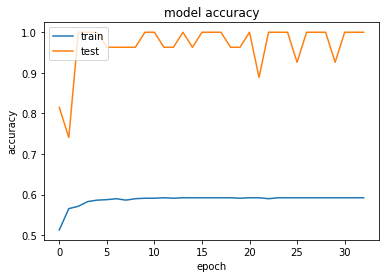

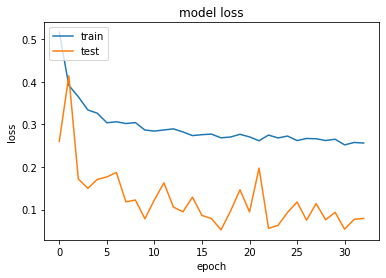

2/2 [==============================] - 2s 125ms/step - loss: 0.2570 - accuracy: 0.9118
Epoch 1/100
28/28 [==============================] - 17s 381ms/step - loss: 0.5281 - accuracy: 0.4831 - val_loss: 0.1552 - val_accuracy: 0.9259
Epoch 2/100
28/28 [==============================] - 9s 332ms/step - loss: 0.4432 - accuracy: 0.5203 - val_loss: 0.1221 - val_accuracy: 1.0000
Epoch 3/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3964 - accuracy: 0.5529 - val_loss: 0.1390 - val_accuracy: 0.9259
Epoch 4/100
28/28 [==============================] - 9s 332ms/step - loss: 0.3506 - accuracy: 0.5541 - val_loss: 0.1108 - val_accuracy: 0.9259
Epoch 5/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3515 - accuracy: 0.5586 - val_loss: 0.1518 - val_accuracy: 1.0000
Epoch 6/100
28/28 [==============================] - 9s 329ms/step - loss: 0.3334 - accuracy: 0.5642 - val_loss: 0.1631 - val_accuracy: 1.0000
Epoch 7/100
28/28 [==============================] - 9

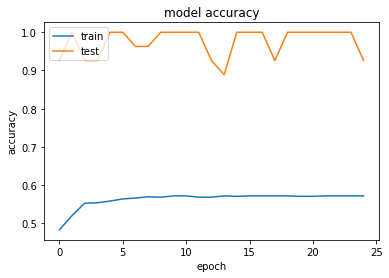

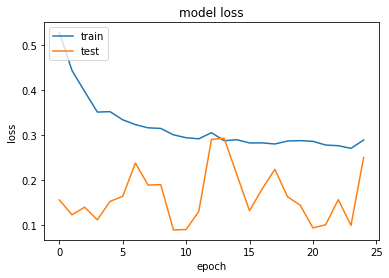

2/2 [==============================] - 1s 125ms/step - loss: 0.0699 - accuracy: 1.0000
Epoch 1/100
27/27 [==============================] - 16s 381ms/step - loss: 0.4702 - accuracy: 0.5355 - val_loss: 0.8226 - val_accuracy: 0.5926
Epoch 2/100
27/27 [==============================] - 9s 329ms/step - loss: 0.3792 - accuracy: 0.5780 - val_loss: 0.4303 - val_accuracy: 0.8148
Epoch 3/100
27/27 [==============================] - 9s 329ms/step - loss: 0.3555 - accuracy: 0.5981 - val_loss: 0.4661 - val_accuracy: 0.7778
Epoch 4/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3314 - accuracy: 0.6017 - val_loss: 0.3704 - val_accuracy: 0.8889
Epoch 5/100
27/27 [==============================] - 9s 329ms/step - loss: 0.3065 - accuracy: 0.6099 - val_loss: 0.2820 - val_accuracy: 0.9259
Epoch 6/100
27/27 [==============================] - 9s 330ms/step - loss: 0.2948 - accuracy: 0.6111 - val_loss: 0.2518 - val_accuracy: 0.9259
Epoch 7/100
27/27 [==============================] - 9

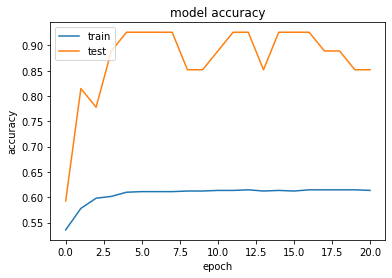

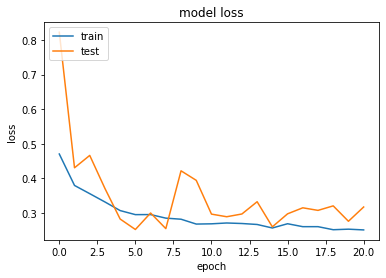

2/2 [==============================] - 2s 125ms/step - loss: 0.1250 - accuracy: 0.9706
Epoch 1/100
27/27 [==============================] - 16s 383ms/step - loss: 0.4825 - accuracy: 0.4905 - val_loss: 0.5801 - val_accuracy: 0.7407
Epoch 2/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3999 - accuracy: 0.5284 - val_loss: 0.4792 - val_accuracy: 0.7778
Epoch 3/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3847 - accuracy: 0.5284 - val_loss: 0.3679 - val_accuracy: 0.7778
Epoch 4/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3548 - accuracy: 0.5437 - val_loss: 0.3595 - val_accuracy: 0.8148
Epoch 5/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3525 - accuracy: 0.5461 - val_loss: 0.2208 - val_accuracy: 0.9259
Epoch 6/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3530 - accuracy: 0.5461 - val_loss: 0.1679 - val_accuracy: 0.9259
Epoch 7/100
27/27 [==============================] - 9

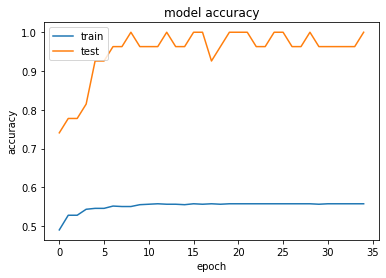

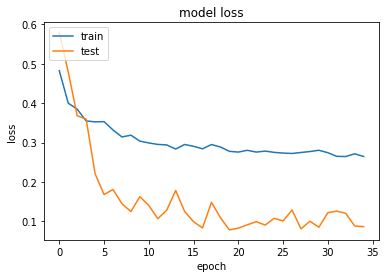

2/2 [==============================] - 2s 129ms/step - loss: 0.1261 - accuracy: 0.9706
Epoch 1/100
28/28 [==============================] - 17s 380ms/step - loss: 0.4680 - accuracy: 0.5205 - val_loss: 0.5195 - val_accuracy: 0.8148
Epoch 2/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3974 - accuracy: 0.5628 - val_loss: 0.3594 - val_accuracy: 0.8148
Epoch 3/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3640 - accuracy: 0.5651 - val_loss: 0.3110 - val_accuracy: 0.8889
Epoch 4/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3393 - accuracy: 0.5788 - val_loss: 0.2811 - val_accuracy: 0.9259
Epoch 5/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3115 - accuracy: 0.5811 - val_loss: 0.2445 - val_accuracy: 0.9259
Epoch 6/100
28/28 [==============================] - 9s 326ms/step - loss: 0.3060 - accuracy: 0.5879 - val_loss: 0.3001 - val_accuracy: 0.8519
Epoch 7/100
28/28 [==============================] - 9

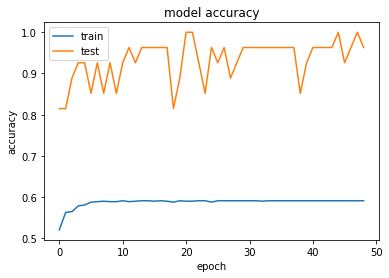

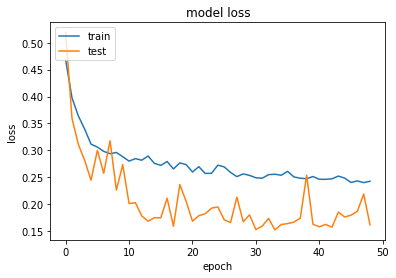

2/2 [==============================] - 2s 124ms/step - loss: 0.0799 - accuracy: 0.9706
[0.9352941155433655, 0.9647058606147766]
[0.9263087228836536, 0.958662613981763]
Epoch 1/100
27/27 [==============================] - 16s 385ms/step - loss: 0.5508 - accuracy: 0.5036 - val_loss: 0.7958 - val_accuracy: 0.6296
Epoch 2/100
27/27 [==============================] - 9s 331ms/step - loss: 0.4459 - accuracy: 0.5321 - val_loss: 0.6211 - val_accuracy: 0.6667
Epoch 3/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3788 - accuracy: 0.5476 - val_loss: 0.4513 - val_accuracy: 0.7407
Epoch 4/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3769 - accuracy: 0.5476 - val_loss: 0.2892 - val_accuracy: 0.8519
Epoch 5/100
27/27 [==============================] - 9s 328ms/step - loss: 0.3526 - accuracy: 0.5619 - val_loss: 0.3386 - val_accuracy: 0.8148
Epoch 6/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3496 - accuracy: 0.5583 - val_loss: 0.2

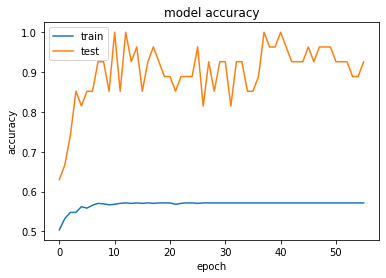

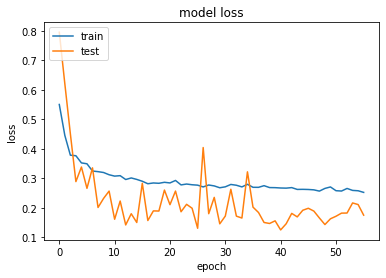

2/2 [==============================] - 2s 123ms/step - loss: 0.0500 - accuracy: 1.0000
Epoch 1/100
28/28 [==============================] - 17s 385ms/step - loss: 0.5317 - accuracy: 0.4853 - val_loss: 0.3744 - val_accuracy: 0.8148
Epoch 2/100
28/28 [==============================] - 9s 331ms/step - loss: 0.4211 - accuracy: 0.5385 - val_loss: 0.2312 - val_accuracy: 0.8889
Epoch 3/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3603 - accuracy: 0.5590 - val_loss: 0.2015 - val_accuracy: 0.8889
Epoch 4/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3443 - accuracy: 0.5714 - val_loss: 0.1835 - val_accuracy: 0.9630
Epoch 5/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3366 - accuracy: 0.5680 - val_loss: 0.1711 - val_accuracy: 0.9630
Epoch 6/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3130 - accuracy: 0.5748 - val_loss: 0.1678 - val_accuracy: 1.0000
Epoch 7/100
28/28 [==============================] - 9

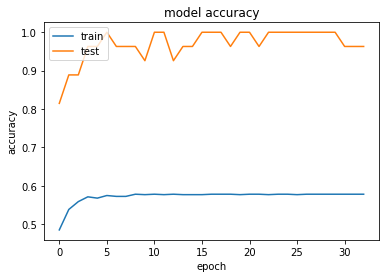

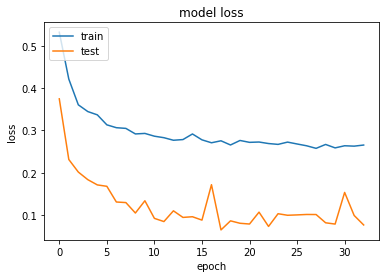

2/2 [==============================] - 2s 127ms/step - loss: 0.3034 - accuracy: 0.8529
Epoch 1/100
28/28 [==============================] - 17s 381ms/step - loss: 0.5144 - accuracy: 0.5126 - val_loss: 0.4237 - val_accuracy: 0.7407
Epoch 2/100
28/28 [==============================] - 9s 330ms/step - loss: 0.4188 - accuracy: 0.5552 - val_loss: 0.3784 - val_accuracy: 0.7407
Epoch 3/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3542 - accuracy: 0.5862 - val_loss: 0.2576 - val_accuracy: 0.9259
Epoch 4/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3388 - accuracy: 0.5828 - val_loss: 0.1847 - val_accuracy: 0.9630
Epoch 5/100
28/28 [==============================] - 9s 327ms/step - loss: 0.3224 - accuracy: 0.5931 - val_loss: 0.1904 - val_accuracy: 1.0000
Epoch 6/100
28/28 [==============================] - 9s 330ms/step - loss: 0.2927 - accuracy: 0.5931 - val_loss: 0.1710 - val_accuracy: 0.9630
Epoch 7/100
28/28 [==============================] - 9

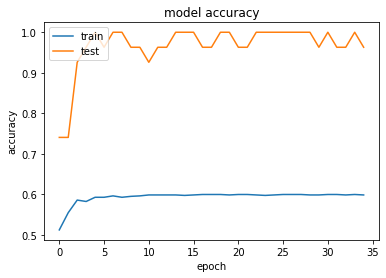

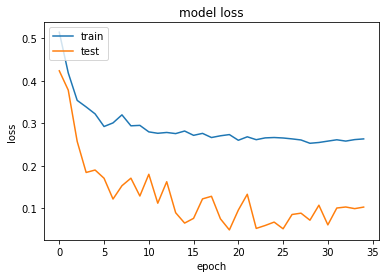

2/2 [==============================] - 2s 125ms/step - loss: 0.0341 - accuracy: 1.0000
Epoch 1/100
28/28 [==============================] - 17s 381ms/step - loss: 0.4861 - accuracy: 0.5251 - val_loss: 0.3590 - val_accuracy: 0.8148
Epoch 2/100
28/28 [==============================] - 9s 330ms/step - loss: 0.4023 - accuracy: 0.5685 - val_loss: 0.2880 - val_accuracy: 0.7778
Epoch 3/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3708 - accuracy: 0.5731 - val_loss: 0.2308 - val_accuracy: 0.9259
Epoch 4/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3340 - accuracy: 0.5879 - val_loss: 0.2057 - val_accuracy: 0.9630
Epoch 5/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3296 - accuracy: 0.5879 - val_loss: 0.2076 - val_accuracy: 0.9259
Epoch 6/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3076 - accuracy: 0.6027 - val_loss: 0.1748 - val_accuracy: 0.9630
Epoch 7/100
28/28 [==============================] - 9

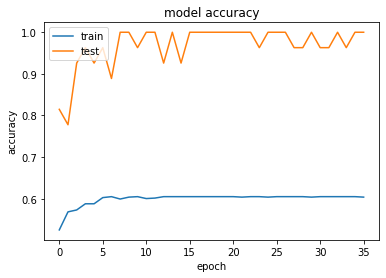

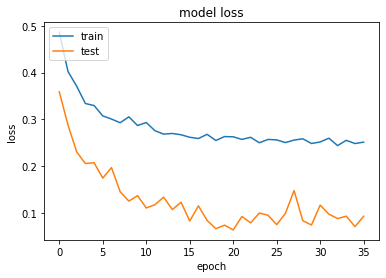

2/2 [==============================] - 2s 118ms/step - loss: 0.1138 - accuracy: 0.9706
Epoch 1/100
28/28 [==============================] - 17s 382ms/step - loss: 0.5627 - accuracy: 0.4676 - val_loss: 0.2730 - val_accuracy: 0.8889
Epoch 2/100
28/28 [==============================] - 9s 332ms/step - loss: 0.4222 - accuracy: 0.5391 - val_loss: 0.1928 - val_accuracy: 0.9259
Epoch 3/100
28/28 [==============================] - 9s 333ms/step - loss: 0.3656 - accuracy: 0.5559 - val_loss: 0.1842 - val_accuracy: 0.8889
Epoch 4/100
28/28 [==============================] - 9s 333ms/step - loss: 0.3594 - accuracy: 0.5570 - val_loss: 0.1756 - val_accuracy: 1.0000
Epoch 5/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3472 - accuracy: 0.5570 - val_loss: 0.1365 - val_accuracy: 0.9630
Epoch 6/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3355 - accuracy: 0.5604 - val_loss: 0.1472 - val_accuracy: 1.0000
Epoch 7/100
28/28 [==============================] - 9

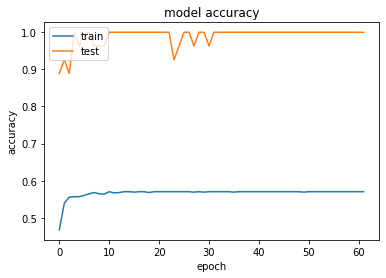

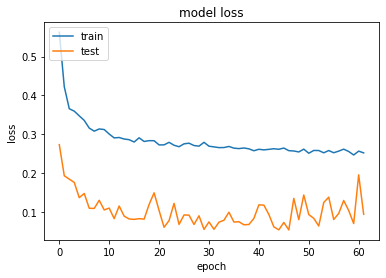

2/2 [==============================] - 2s 120ms/step - loss: 0.1008 - accuracy: 1.0000
[0.9352941155433655, 0.9647058606147766, 0.9647058725357056]
[0.9263087228836536, 0.958662613981763, 0.9538947493891173]
Epoch 1/100
28/28 [==============================] - 17s 381ms/step - loss: 0.5508 - accuracy: 0.4751 - val_loss: 0.3315 - val_accuracy: 0.8519
Epoch 2/100
28/28 [==============================] - 9s 331ms/step - loss: 0.4282 - accuracy: 0.5295 - val_loss: 0.2241 - val_accuracy: 0.8889
Epoch 3/100
28/28 [==============================] - 9s 332ms/step - loss: 0.3992 - accuracy: 0.5397 - val_loss: 0.1926 - val_accuracy: 0.8889
Epoch 4/100
28/28 [==============================] - 9s 332ms/step - loss: 0.3598 - accuracy: 0.5658 - val_loss: 0.1529 - val_accuracy: 1.0000
Epoch 5/100
28/28 [==============================] - 9s 331ms/step - loss: 0.3479 - accuracy: 0.5658 - val_loss: 0.1504 - val_accuracy: 0.9630
Epoch 6/100
28/28 [==============================] - 9s 331ms/step - loss: 0

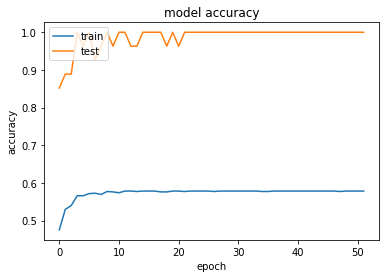

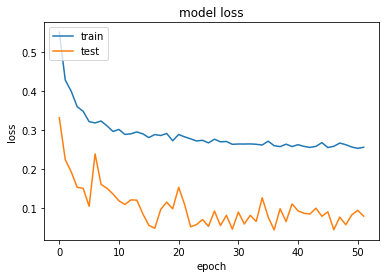

2/2 [==============================] - 2s 123ms/step - loss: 0.0524 - accuracy: 0.9706
Epoch 1/100
27/27 [==============================] - 16s 394ms/step - loss: 0.5571 - accuracy: 0.4826 - val_loss: 0.5372 - val_accuracy: 0.7407
Epoch 2/100
27/27 [==============================] - 9s 331ms/step - loss: 0.4108 - accuracy: 0.5556 - val_loss: 0.4684 - val_accuracy: 0.7407
Epoch 3/100
27/27 [==============================] - 9s 332ms/step - loss: 0.3748 - accuracy: 0.5648 - val_loss: 0.3461 - val_accuracy: 0.8519
Epoch 4/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3501 - accuracy: 0.5787 - val_loss: 0.2778 - val_accuracy: 0.8519
Epoch 5/100
27/27 [==============================] - 9s 332ms/step - loss: 0.3162 - accuracy: 0.5833 - val_loss: 0.2133 - val_accuracy: 0.9630
Epoch 6/100
27/27 [==============================] - 9s 333ms/step - loss: 0.3085 - accuracy: 0.5880 - val_loss: 0.2365 - val_accuracy: 0.8889
Epoch 7/100
27/27 [==============================] - 9

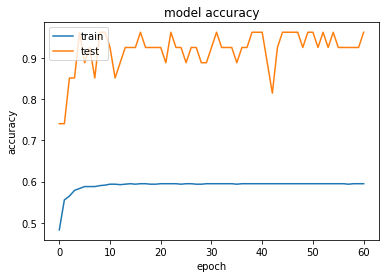

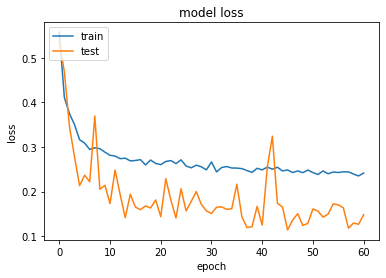

2/2 [==============================] - 2s 129ms/step - loss: 0.0858 - accuracy: 0.9706
Epoch 1/100
28/28 [==============================] - 17s 381ms/step - loss: 0.5385 - accuracy: 0.5102 - val_loss: 0.2152 - val_accuracy: 0.8889
Epoch 2/100
28/28 [==============================] - 9s 327ms/step - loss: 0.3848 - accuracy: 0.5601 - val_loss: 0.1679 - val_accuracy: 0.8889
Epoch 3/100
28/28 [==============================] - 9s 325ms/step - loss: 0.3612 - accuracy: 0.5794 - val_loss: 0.1848 - val_accuracy: 0.9630
Epoch 4/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3290 - accuracy: 0.5896 - val_loss: 0.1517 - val_accuracy: 0.9630
Epoch 5/100
28/28 [==============================] - 9s 329ms/step - loss: 0.3323 - accuracy: 0.5850 - val_loss: 0.1210 - val_accuracy: 1.0000
Epoch 6/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3014 - accuracy: 0.5952 - val_loss: 0.1180 - val_accuracy: 1.0000
Epoch 7/100
28/28 [==============================] - 9

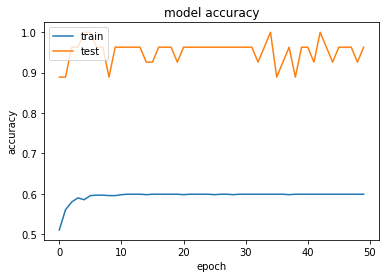

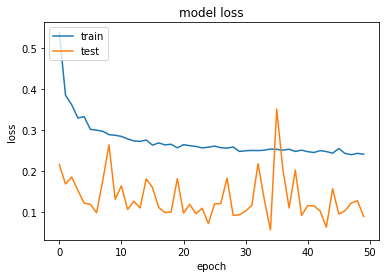

2/2 [==============================] - 2s 121ms/step - loss: 0.2140 - accuracy: 0.9412
Epoch 1/100
28/28 [==============================] - 17s 379ms/step - loss: 0.5520 - accuracy: 0.5046 - val_loss: 0.6036 - val_accuracy: 0.7778
Epoch 2/100
28/28 [==============================] - 9s 329ms/step - loss: 0.4032 - accuracy: 0.5594 - val_loss: 0.3577 - val_accuracy: 0.8519
Epoch 3/100
28/28 [==============================] - 9s 326ms/step - loss: 0.3727 - accuracy: 0.5731 - val_loss: 0.2999 - val_accuracy: 0.8519
Epoch 4/100
28/28 [==============================] - 9s 329ms/step - loss: 0.3635 - accuracy: 0.5799 - val_loss: 0.2717 - val_accuracy: 0.8519
Epoch 5/100
28/28 [==============================] - 9s 325ms/step - loss: 0.3332 - accuracy: 0.5811 - val_loss: 0.2917 - val_accuracy: 0.9259
Epoch 6/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3337 - accuracy: 0.5788 - val_loss: 0.2524 - val_accuracy: 0.9630
Epoch 7/100
28/28 [==============================] - 9

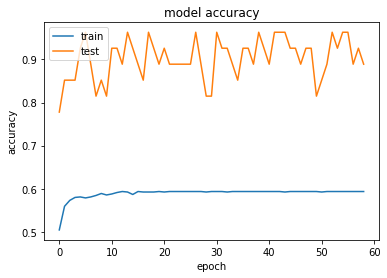

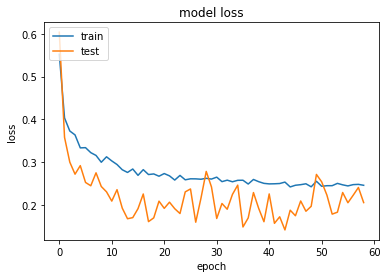

2/2 [==============================] - 2s 123ms/step - loss: 0.0735 - accuracy: 0.9706
Epoch 1/100
27/27 [==============================] - 16s 382ms/step - loss: 0.5742 - accuracy: 0.4643 - val_loss: 1.0805 - val_accuracy: 0.4815
Epoch 2/100
27/27 [==============================] - 9s 331ms/step - loss: 0.4345 - accuracy: 0.5179 - val_loss: 0.6445 - val_accuracy: 0.6667
Epoch 3/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3920 - accuracy: 0.5381 - val_loss: 0.5473 - val_accuracy: 0.7778
Epoch 4/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3809 - accuracy: 0.5429 - val_loss: 0.4143 - val_accuracy: 0.7778
Epoch 5/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3609 - accuracy: 0.5476 - val_loss: 0.3091 - val_accuracy: 0.8889
Epoch 6/100
27/27 [==============================] - 9s 328ms/step - loss: 0.3420 - accuracy: 0.5560 - val_loss: 0.3187 - val_accuracy: 0.8519
Epoch 7/100
27/27 [==============================] - 9

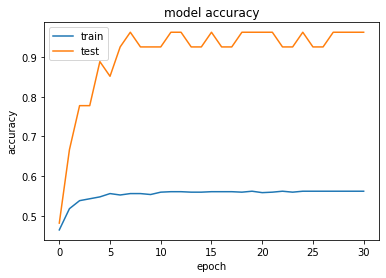

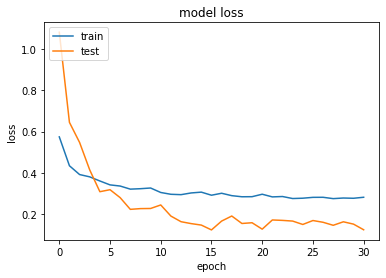

2/2 [==============================] - 2s 126ms/step - loss: 0.1109 - accuracy: 0.9706
[0.9352941155433655, 0.9647058606147766, 0.9647058725357056, 0.9647058606147766]
[0.9263087228836536, 0.958662613981763, 0.9538947493891173, 0.9585945920150362]
Epoch 1/100
28/28 [==============================] - 17s 380ms/step - loss: 0.5200 - accuracy: 0.4966 - val_loss: 0.2240 - val_accuracy: 0.9259
Epoch 2/100
28/28 [==============================] - 9s 326ms/step - loss: 0.4164 - accuracy: 0.5411 - val_loss: 0.2323 - val_accuracy: 1.0000
Epoch 3/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3973 - accuracy: 0.5525 - val_loss: 0.1778 - val_accuracy: 0.9259
Epoch 4/100
28/28 [==============================] - 9s 327ms/step - loss: 0.3561 - accuracy: 0.5605 - val_loss: 0.1807 - val_accuracy: 1.0000
Epoch 5/100
28/28 [==============================] - 9s 329ms/step - loss: 0.3469 - accuracy: 0.5628 - val_loss: 0.1243 - val_accuracy: 1.0000
Epoch 6/100
28/28 [=================

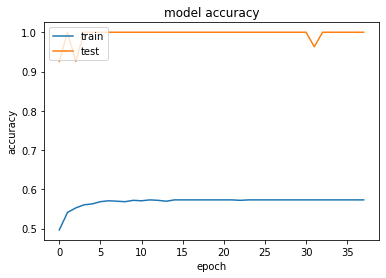

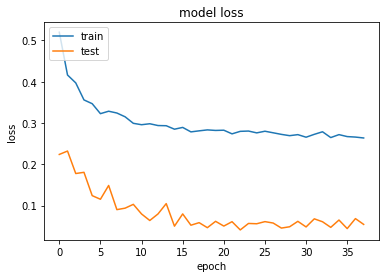

2/2 [==============================] - 2s 123ms/step - loss: 0.1223 - accuracy: 0.9412
Epoch 1/100
27/27 [==============================] - 16s 382ms/step - loss: 0.4969 - accuracy: 0.5128 - val_loss: 0.4094 - val_accuracy: 0.7778
Epoch 2/100
27/27 [==============================] - 9s 331ms/step - loss: 0.4189 - accuracy: 0.5361 - val_loss: 0.3236 - val_accuracy: 0.8148
Epoch 3/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3791 - accuracy: 0.5548 - val_loss: 0.2473 - val_accuracy: 0.9259
Epoch 4/100
27/27 [==============================] - 9s 331ms/step - loss: 0.3480 - accuracy: 0.5606 - val_loss: 0.2319 - val_accuracy: 0.9259
Epoch 5/100
27/27 [==============================] - 9s 328ms/step - loss: 0.3517 - accuracy: 0.5606 - val_loss: 0.2862 - val_accuracy: 0.8148
Epoch 6/100
27/27 [==============================] - 9s 328ms/step - loss: 0.3271 - accuracy: 0.5711 - val_loss: 0.3675 - val_accuracy: 0.8519
Epoch 7/100
27/27 [==============================] - 9

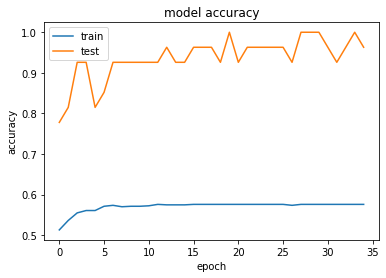

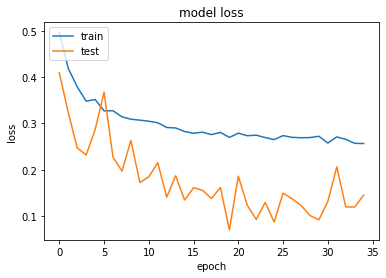

2/2 [==============================] - 2s 122ms/step - loss: 0.0947 - accuracy: 1.0000
Epoch 1/100
27/27 [==============================] - 17s 383ms/step - loss: 0.5466 - accuracy: 0.4883 - val_loss: 0.5826 - val_accuracy: 0.7037
Epoch 2/100
27/27 [==============================] - 9s 327ms/step - loss: 0.4137 - accuracy: 0.5516 - val_loss: 0.5254 - val_accuracy: 0.7037
Epoch 3/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3799 - accuracy: 0.5610 - val_loss: 0.3918 - val_accuracy: 0.7778
Epoch 4/100
27/27 [==============================] - 9s 327ms/step - loss: 0.3461 - accuracy: 0.5739 - val_loss: 0.4229 - val_accuracy: 0.7778
Epoch 5/100
27/27 [==============================] - 9s 328ms/step - loss: 0.3391 - accuracy: 0.5763 - val_loss: 0.2990 - val_accuracy: 0.8148
Epoch 6/100
27/27 [==============================] - 9s 330ms/step - loss: 0.3313 - accuracy: 0.5822 - val_loss: 0.2448 - val_accuracy: 0.8519
Epoch 7/100
27/27 [==============================] - 9

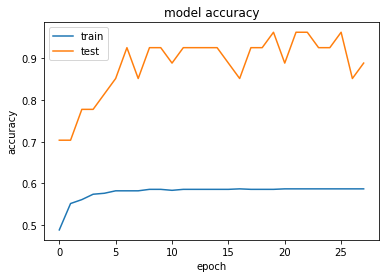

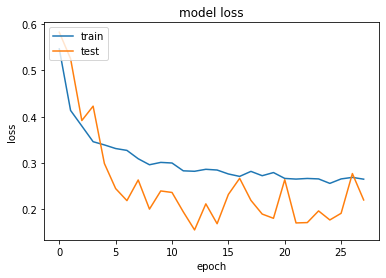

2/2 [==============================] - 2s 130ms/step - loss: 0.0618 - accuracy: 1.0000
Epoch 1/100
28/28 [==============================] - 17s 381ms/step - loss: 0.5508 - accuracy: 0.4888 - val_loss: 0.2523 - val_accuracy: 0.9259
Epoch 2/100
28/28 [==============================] - 9s 329ms/step - loss: 0.4166 - accuracy: 0.5515 - val_loss: 0.2232 - val_accuracy: 0.9630
Epoch 3/100
28/28 [==============================] - 9s 327ms/step - loss: 0.3685 - accuracy: 0.5749 - val_loss: 0.1857 - val_accuracy: 0.9630
Epoch 4/100
28/28 [==============================] - 9s 330ms/step - loss: 0.3474 - accuracy: 0.5828 - val_loss: 0.1849 - val_accuracy: 0.9259
Epoch 5/100
28/28 [==============================] - 9s 329ms/step - loss: 0.3173 - accuracy: 0.5962 - val_loss: 0.1490 - val_accuracy: 1.0000
Epoch 6/100
28/28 [==============================] - 9s 328ms/step - loss: 0.3141 - accuracy: 0.5951 - val_loss: 0.1383 - val_accuracy: 1.0000
Epoch 7/100
28/28 [==============================] - 9

In [ ]:
t = time.time()
# ---------- Parameters ----------------
augmentation_enable = True
normalize_inputs_enable = True
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = None) # random_state = 1 ile split run'dan run'a sabit.
test_accuracy_per_run = []
f1_score_per_run = []
epoch_number = 100
batch_size = 32
dense_size = 64
dropout_prob_dense = 0.5 # 0.
repeat_of_mixup = 5
number_of_repeat = 5
unit_number_of_lstm = 16 #8 16 32
dense_unit_of_range_doppler_function = 128 #128 256 512
dense_unit_of_spectrogram_function = 8
decoder_dense_unit = 256
for repeat_run_number in range(number_of_repeat):
  test_accuracy_per_fold = []
  f1_score_per_fold = []
  if repeat_run_number > 0:
    del range_doppler_concat_shuffle_test
    del spectrogram_concat_shuffle_test
    del range_doppler_augmented_image
    del range_doppler_concat_shuffle_train
    del spectrogram_concat_shuffle_train
    del spectrogram_augmented_image
   
  for randomlist_for_train_indx, randomlist_for_test_indx in kfold.split(range_doppler_concat_shuffle,range_doppler_concat_label_shuffle):   
    gc.collect()
    K.clear_session()
    
    # test data
    range_doppler_concat_shuffle_test = range_doppler_concat_shuffle[randomlist_for_test_indx,:,:,:]
    spectrogram_concat_shuffle_test = spectrogram_concat_shuffle[randomlist_for_test_indx,:,:,:]
    range_doppler_concat_label_shuffle_test = range_doppler_concat_label_shuffle[randomlist_for_test_indx,:]
    #train data
    range_doppler_concat_shuffle_train = range_doppler_concat_shuffle[randomlist_for_train_indx,:,:,:]
    spectrogram_concat_shuffle_train = spectrogram_concat_shuffle[randomlist_for_train_indx,:,:,:]
    spectrogram_concat_label_shuffle_train = spectrogram_concat_label_shuffle[randomlist_for_train_indx,:]
      # ---------------- MixUp Augmentation ----------------
    (spectrogram_augmented_image,range_doppler_augmented_image,spectrogram_concat_label_shuffle_concat,\
     validation_spectrogram,validation_range_doppler, spectrogram_validation_labels)  =\
      split_and_augmentation_of_training(spectrogram_concat_shuffle_train,range_doppler_concat_shuffle_train,\
                                         spectrogram_concat_label_shuffle_train,\
                                         repeat_of_mixup, augmentation_enable)
    
    # ---------------- Neural Network Architecture ----------------



    def lstm_encoder_network_1(input_shape):
        input = Input(shape=input_shape)
        x = Bidirectional(LSTM(unit_number_of_lstm, return_sequences=True, dropout = 0.5))(input)
        x = Flatten()(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(dense_unit_of_range_doppler_function)(x)
        x = BatchNormalization()(x)
        x = Activation('LeakyReLU')(x)
        x = Dropout(dropout_prob_dense)(x)
        return Model(input, x)

    def lstm_encoder_network_2(input_shape):
        input = Input(shape=input_shape)
        x = Bidirectional(LSTM(unit_number_of_lstm, return_sequences=True, dropout = 0.5))(input)
        x = Flatten()(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(dense_unit_of_spectrogram_function)(x)
        x = BatchNormalization()(x)
        x = Activation('LeakyReLU')(x)
        x = Dropout(dropout_prob_dense)(x)
        return Model(input, x)

    def decoder_for_concat(input_shape):
      input = Input(shape=input_shape)
      x = Dense(decoder_dense_unit)(input)
      x = BatchNormalization()(x)
      x = Activation('LeakyReLU')(x)
      x = Dropout(0.3)(x)
      x = Dense(dense_size)(x)
      # x = BatchNormalization()(x)
      x = Activation('LeakyReLU')(x)
      x = Dropout(dropout_prob_dense)(x)
      x = Dense(1, activation="sigmoid")(x)
      return Model(input, x)

    input_shape = range_doppler_concat_shuffle.shape[1:3]
    base_network_lstm = lstm_encoder_network_1(input_shape)
    range_doppler_input  = Input(shape=input_shape)
    processed_range_doppler  = base_network_lstm(range_doppler_input)

    input_shape = spectrogram_concat_shuffle_train.shape[1:3]
    base_network_lstm_2 = lstm_encoder_network_2(input_shape)
    spectrogram_input  = Input(shape=input_shape)
    processed_spectrogram  = base_network_lstm_2(spectrogram_input)

    concat_layer = Concatenate()([processed_range_doppler, processed_spectrogram])

    base_decoder_network = decoder_for_concat((concat_layer.shape[1]))
    out = base_decoder_network(concat_layer)

    model = Model(inputs=[range_doppler_input, spectrogram_input], outputs=[out]) 
    if repeat_run_number == 0:
      print(base_network_lstm.summary())
      print(base_network_lstm_2.summary())
      print(base_decoder_network.summary())
    # ---------------- Compile and Fit ----------------
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0,restore_best_weights=True, mode='min')
    history = model.fit((range_doppler_augmented_image, spectrogram_augmented_image),(spectrogram_concat_label_shuffle_concat),
                    epochs=epoch_number,
                    batch_size=batch_size,
                    shuffle = True,
                    callbacks=[earlyStopping],
                    validation_data = ((validation_range_doppler, validation_spectrogram) , (spectrogram_validation_labels)))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    test_loss, test_accuracy  = model.evaluate([range_doppler_concat_shuffle_test, spectrogram_concat_shuffle_test],\
                                               [range_doppler_concat_label_shuffle_test],
                  batch_size=batch_size)
    gc.collect()
    # ---------------- Get Test Results ----------------
    y_test_predicted = model.predict((range_doppler_concat_shuffle_test, spectrogram_concat_shuffle_test), batch_size=batch_size)
    # ----- Binarize y_test_predicted values -----
    y_test_predicted_binary = np.zeros(y_test_predicted.size)
    for ii in range(y_test_predicted.size):
      if y_test_predicted[ii] < 0.5:
        y_test_predicted_binary[ii] = 0
      else:
        y_test_predicted_binary[ii] = 1
    
    test_precision, test_recall, test_f1_score, support = precision_recall_fscore_support(range_doppler_concat_label_shuffle_test, y_test_predicted_binary, average='macro')

    test_accuracy_per_fold.append(test_accuracy)
    f1_score_per_fold.append(test_f1_score)
    del model
  test_accuracy_per_run.append(sum(test_accuracy_per_fold)/num_folds)
  f1_score_per_run.append(sum(f1_score_per_fold)/num_folds)
  print(test_accuracy_per_run)
  print(f1_score_per_run)
print(f'Mean test accuracy is {"{:.3f}".format(sum(test_accuracy_per_run)/number_of_repeat)}, mean test f1 score is {"{:.3f}".format(sum(f1_score_per_run)/number_of_repeat)}, \
max test accuracy is {"{:.3f}".format(max(test_accuracy_per_run))}, max test f1 score is {"{:.3f}".format(max(f1_score_per_run))}, \
min test accuracy is {"{:.3f}".format(min(test_accuracy_per_run))}, min test f1 score is {"{:.3f}".format(min(f1_score_per_run))}, \
std of test accuracy is {"{:.3f}".format(np.std(test_accuracy_per_run, axis=0))}, std of test f1 score is {"{:.3f}".format(np.std(f1_score_per_run, axis=0))}')
elapsed = time.time() - t
print(f'Time elapsed through all process: {"{:.3f}".format(elapsed)}, sec')

In [9]:
print(f'Mean test accuracy is {"{:.3f}".format(sum(test_accuracy_per_run)/number_of_repeat)}, mean test f1 score is {"{:.3f}".format(sum(f1_score_per_run)/number_of_repeat)}, \
max test accuracy is {"{:.3f}".format(max(test_accuracy_per_run))}, max test f1 score is {"{:.3f}".format(max(f1_score_per_run))}, \
min test accuracy is {"{:.3f}".format(min(test_accuracy_per_run))}, min test f1 score is {"{:.3f}".format(min(f1_score_per_run))}, \
std of test accuracy is {"{:.3f}".format(np.std(test_accuracy_per_run, axis=0))}, std of test f1 score is {"{:.3f}".format(np.std(f1_score_per_run, axis=0))}')
print(f'Time elapsed through all process: {"{:.3f}".format(elapsed)}, sec')

Mean test accuracy is 0.960, mean test f1 score is 0.952, max test accuracy is 0.971, max test f1 score is 0.965, min test accuracy is 0.935, min test f1 score is 0.926, std of test accuracy is 0.013, std of test f1 score is 0.013
Time elapsed through all process: 9692.637, sec


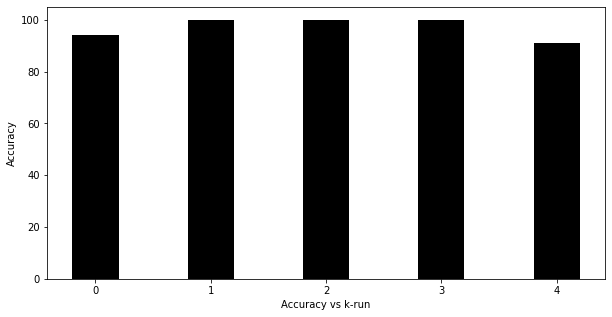

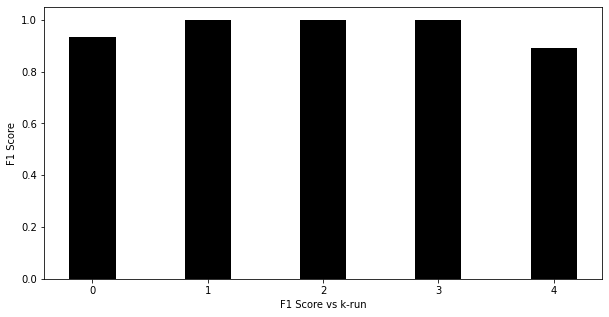

In [10]:

import numpy as np
import matplotlib.pyplot as plt
def createList(n):
    lst = []
    for i in range(n+1):
        lst.append(i)
    return(lst)


folds = createList(4)
values = [element * 100 for element in test_accuracy_per_fold]

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(folds, values, color ='black',
        width = 0.4)
plt.xlabel("Accuracy vs k-run")
plt.ylabel("Accuracy")
plt.show()

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(folds, f1_score_per_fold, color ='black',
        width = 0.4)
plt.xlabel("F1 Score vs k-run")
plt.ylabel("F1 Score")
plt.show()

